In [1]:
## IMPORTS ## 
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 
!pip install mpld3
import mpld3
mpld3.enable_notebook()

from scipy.integrate import odeint
!pip install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian

import warnings
warnings.filterwarnings('ignore')

In [2]:
## DICTS ## 
beds = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/beds.csv", header=0)
agegroups = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/agegroups.csv")
probabilities = pd.read_csv("https://raw.githubusercontent.com/hf2000510/infectious_disease_modelling/master/data/probabilities.csv")


beds_lookup = dict(zip(beds["Country"], beds["ICU_Beds"]))
agegroup_lookup = dict(zip(agegroups['Location'], agegroups[['0_9', '10_19', '20_29', '30_39', '40_49', '50_59', '60_69', '70_79', '80_89', '90_100']].values))



In [3]:
## PROBS ## 
prob_I_to_C_1 = list(probabilities.prob_I_to_ICU_1.values)
prob_I_to_C_2 = list(probabilities.prob_I_to_ICU_2.values)
prob_C_to_Death_1 = list(probabilities.prob_ICU_to_Death_1.values)
prob_C_to_Death_2 = list(probabilities.prob_ICU_to_Death_2.values)

# PLOT 

In [4]:
plt.gcf().subplots_adjust(bottom=0.15)

def plotter(t, S, E, I, C, R, D, V1, V2, R_0, B, S_1=None, S_2=None, x_ticks=None):
    if S_1 is not None and S_2 is not None:
        print(f"percentage going to ICU: {S_1*100}; percentage dying in ICU: {S_2 * 100}")


    f, ax = plt.subplots(1,1,figsize=(10,5))
    
    if x_ticks is None:
        #ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(t, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
       # ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
       # ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        #ax.plot(t, V1, 'cyan', alpha=0.7, linewidth=2, label='First Dose')
       # ax.plot(t, V2, 'orange', alpha=0.7, linewidth=2, label='Second Dose')

       # ax.plot(t, S+E+I+R+D+C+V1+V2, 'c--', alpha=0.7, linewidth=2, label='Total')

    else:
        #ax.plot(x_ticks, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
        ax.plot(x_ticks, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
        ax.plot(x_ticks, I, 'r', alpha=0.7, linewidth=2, label='Infected')
        ax.plot(x_ticks, C, 'r--', alpha=0.7, linewidth=2, label='Critical')
       # ax.plot(x_ticks, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
        ax.plot(x_ticks, D, 'k', alpha=0.7, linewidth=2, label='Dead')
        #ax.plot(x_ticks, V1, 'cyan', alpha=0.7, linewidth=2, label='First Dose')
        #ax.plot(x_ticks, V2, 'orange', alpha=0.7, linewidth=2, label='Second Dose')
        #ax.plot(x_ticks, S+E+I+R+D+C+V1+V2, 'c--', alpha=0.7, linewidth=2, label='Total')

        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax.title.set_text('SEICRDV-Model')

    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

        
    plt.tight_layout(pad=5.0)
    plt.savefig("SEICRD_Canada.pdf")

    f = plt.figure(figsize=(10,4))
    
    
    # sp1
    ax1 = f.add_subplot(131)
    if x_ticks is None:
        ax1.plot(t, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
    else:
        ax1.plot(x_ticks, R_0, 'b--', alpha=0.7, linewidth=2, label='R_0')
        ax1.xaxis.set_major_locator(mdates.YearLocator())
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax1.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

 
    ax1.title.set_text('R_0 over time')
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
        
  # sp2
    ax2 = f.add_subplot(132)
    total_CFR = [0] + [100 * D[i] / sum(sigma*E[:i]) if sum(sigma*E[:i])>0 else 0 for i in range(1, len(t))]
    daily_CFR = [0] + [100 * ((D[i]-D[i-1]) / ((R[i]-R[i-1]) + (D[i]-D[i-1]))) if max((R[i]-R[i-1]), (D[i]-D[i-1]))>10 else 0 for i in range(1, len(t))]
    if x_ticks is None:
        ax2.plot(t, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(t, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
    else:
        ax2.plot(x_ticks, total_CFR, 'r--', alpha=0.7, linewidth=2, label='total')
        ax2.plot(x_ticks, daily_CFR, 'b--', alpha=0.7, linewidth=2, label='daily')
        ax2.xaxis.set_major_locator(mdates.YearLocator())
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax2.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax2.title.set_text('Fatality Rate (%)')
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
        
  # sp3
    ax3 = f.add_subplot(133)
    newDs = [0] + [D[i]-D[i-1] for i in range(1, len(t))]
    if x_ticks is None:
        ax3.plot(t, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(t, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
    else:
        ax3.plot(x_ticks, newDs, 'r--', alpha=0.7, linewidth=2, label='total')
        ax3.plot(x_ticks, [max(0, C[i]-B(i)) for i in range(len(t))], 'b--', alpha=0.7, linewidth=2, label="over capacity")
        ax3.xaxis.set_major_locator(mdates.YearLocator())
        ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax3.xaxis.set_minor_locator(mdates.MonthLocator())
        f.autofmt_xdate()

    ax3.title.set_text('Deaths per day')
    ax3.yaxis.set_tick_params(length=0)
    ax3.xaxis.set_tick_params(length=0)
    ax3.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax3.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)

plt.savefig("SEICRD_Canada_sp.pdf")
        
    
    


<Figure size 432x288 with 0 Axes>

# Model

In [5]:
def deriv(y, t, beta, gamma, sigma, N, p_I_to_C, p_C_to_D, Beds, alpha1, alpha2, epsilon1, epsilon2):
    S, E, I, C, R, D, V1, V2 = y

    if t < 420: # vax begins
        dSdt = -beta(t) * I * S / N
        dEdt = beta(t) * I * S / N - sigma * E
        dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
        dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
        dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
        dV1dt = 0 
        dV2dt = 0 
        
    elif t < 520: # second dose vax begins 
        dSdt = -beta(t) * I * S / N - (alpha1 * S) 
        dEdt = beta(t) * I * S / N + ((1 - epsilon1) * beta(t) * V1 * I / N) - sigma * E
        dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I 
        dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
        dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
        dV1dt = (alpha1 * S) - ((1 - epsilon1) * beta(t) * V1 * I / N) 
        dV2dt = 0 
        
    else: 
        dSdt = -beta(t) * I * S / N - (alpha1 * S) 
        dEdt = beta(t) * I * S / N + ((1 - epsilon1) * beta(t) * V1 * I / N)+ ((1 - epsilon2) * beta(t) * V2 * I / N) - sigma * E
        dIdt = sigma * E - 1/12.0 * p_I_to_C * I - gamma * (1 - p_I_to_C) * I
        dCdt = 1/12.0 * p_I_to_C * I - 1/7.5 * p_C_to_D * min(Beds(t), C) - max(0, C-Beds(t)) - (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
        dRdt = gamma * (1 - p_I_to_C) * I + (1 - p_C_to_D) * 1/6.5 * min(Beds(t), C)
        dDdt = 1/7.5 * p_C_to_D * min(Beds(t), C) + max(0, C-Beds(t))
        dV1dt = (alpha1 * S) - ((1 - epsilon1) * beta(t) * V1 * I / N) - (alpha2 * V1)
        dV2dt = (alpha2 * V1) - ((1 - epsilon2) * beta(t) * V2 * I / N)
 
    return dSdt, dEdt, dIdt, dCdt, dRdt, dDdt, dV1dt, dV2dt


In [6]:
gamma = 1.0/10
sigma = 1.0/5.0
epsilon1 = 0.83 
epsilon2 = 0.94 # vaccine is 95% efficient
alpha1 = 0.0075
alpha2 = 0.035

In [7]:


def logistic_R_0(t, R_0_start, k, x0, R_0_end, R_1_start, k1, x1, R_1_end, k2, x2, R_2_start, k3, x3, R_2_end, k4, x4, R_current, k5, x5):
    if t < x1:
        R0 = (R_0_start-R_0_end) / (1 + np.exp(k*(t-x0))) + R_0_end # lockdown 1 
    elif x1 <= t < x2: 
        R0 = (R_0_end-R_1_start) / (1 + np.exp(k1*(t-x1))) + R_1_start # ease
    elif x2 <= t < x3: 
        R0 = (R_1_start-R_1_end) / (1 + np.exp(k2*(t-x2))) + R_1_end # lockdown 2
    elif x3 <= t < x4: 
        R0 = (R_1_end-R_2_start) / (1 + np.exp(k3*(t-x3))) + R_2_start # ease
    elif x4 <= t < x5: 
        R0 = (R_2_start-R_2_end) / (1 + np.exp(k4*(t-x4))) + R_2_end # lockdown 3
    else: 
        R0 = (R_2_end-R_current) / (1 + np.exp(k5*(t-x5))) + R_current # ease
    return R0

def Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s, R_1_start, k1, x1, R_1_end, k2, x2, R_2_start, k3, x3, R_2_end, k4, x4, R_current, k5, x5):

    def beta(t):
        return logistic_R_0(t, R_0_start, k, x0, R_0_end, R_1_start, k1, x1, R_1_end, k2, x2, R_2_start, k3, x3, R_2_end, k4, x4, R_current, k5, x5) * gamma

    N = sum(agegroups)
    
    def Beds(t):
        beds_0 = beds_per_100k / 100_000 * N
        return beds_0 + s*beds_0*t  # 0.003

    y0 = N-1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    t = np.linspace(0, days-1, days)
    ret = odeint(deriv, y0, t, args=(beta, gamma, sigma, N, prob_I_to_C, prob_C_to_D, Beds,alpha1,alpha2,epsilon1,epsilon2))
    S, E, I, C, R, D, V1, V2 = ret.T
    R_0_over_time = [beta(i)/gamma for i in range(len(t))]

    return t, S, E, I, C, R, D, V1, V2, R_0_over_time, Beds, prob_I_to_C, prob_C_to_D

# Curve Fit

In [8]:

# parameters
canada_data = pd.read_csv("data/canada_data_for_model.csv",parse_dates=True, index_col=['date'])
data=canada_data.iloc[:,2].values 
agegroups = agegroup_lookup["Canada"]
beds_per_100k = beds_lookup["Canada"]
outbreak_shift = 0

params_init_min_max = {"R_0_start": (3, 2.0, 4.5), "k": (2.5, 0.01, 5.0), "x0": (70, 0, 100), "R_0_end": (0.8, 0.5, 1.5),
                       "prob_I_to_C": (0.05, 0.01, 0.1), "prob_C_to_D": (0.08, 0.05, 0.5),
                       "s": (0.003, 0.001, 0.01), "R_1_start":(1.3, 1, 2), "k1":(4.5, 0.01, 5.0), "x1":(200, 150,250),
                       "R_1_end":(0.75, 0.5, 1.5), "k2":(2, 0.01, 5.0), "x2":(360, 300,375), 
                       "R_2_start":(1.7, 1, 2), "k3":(5, 0.01, 10), "x3":(420,375,450),
                       "R_2_end":(0.6, 0.3, 1), "k4":(2, 0.01, 5.0), "x4":(470, 450,500),
                       "R_current":(4, 2, 5), "k5":(2, 0.01, 5.0), "x5":(530, 500,550)} 



In [9]:
days = outbreak_shift + len(data)
if outbreak_shift >= 0:
    y_data = np.concatenate((np.zeros(outbreak_shift), data))
else:
    y_data = data[-outbreak_shift:]

x_data = np.linspace(0, days - 1, days, dtype=int)  # x_data is just [0, 1, ..., max_days] array



In [10]:
def fitter(x, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s, R_1_start, k1, x1, R_1_end, k2, x2, R_2_start, k3, x3, R_2_end, k4, x4, R_current, k5, x5):
    ret = Model(days, agegroups, beds_per_100k, R_0_start, k, x0, R_0_end, prob_I_to_C, prob_C_to_D, s,R_1_start, k1, x1, R_1_end, k2, x2, R_2_start, k3, x3, R_2_end, k4, x4, R_current, k5, x5)
    return ret[6][x]

In [11]:
mod = lmfit.Model(fitter)

for kwarg, (init, mini, maxi) in params_init_min_max.items():
    mod.set_param_hint(str(kwarg), value=init, min=mini, max=maxi, vary=True)

params = mod.make_params()

In [12]:
result = mod.fit(y_data, params, method="least_squares", x=x_data)

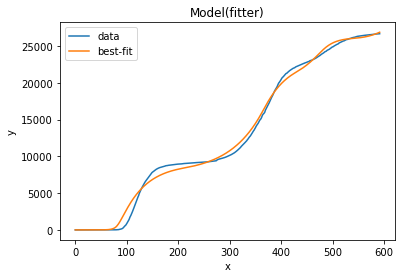

In [13]:
result.plot_fit(datafmt="-");
plt.savefig("canada_death_curve_fit.pdf")


In [22]:
import math
# RMSE??? 
rmse = math.sqrt(result.residual.var() / len(y_data))
rmse / 27000
# normalized: rmse / 27000

0.0009557576262487356

In [15]:
result.best_values


{'R_0_start': 4.499455363266835,
 'k': 1.9395303184776513,
 'x0': 77.74143993690384,
 'R_0_end': 0.694081553633982,
 'prob_I_to_C': 0.08524824323148907,
 'prob_C_to_D': 0.3009455377745709,
 's': 0.003000000000000006,
 'R_1_start': 1.2514954173117332,
 'k1': 3.3335538264931364,
 'x1': 201.11760180633848,
 'R_1_end': 0.7065945918966786,
 'k2': 1.8660671922635963,
 'x2': 357.7461462970882,
 'R_2_start': 1.451863130429747,
 'k3': 4.719804931497197,
 'x3': 420.43575859980297,
 'R_2_end': 0.6294735667442417,
 'k4': 2.024041294038425,
 'x4': 469.9734265211865,
 'R_current': 4.003371684186979,
 'k5': 2.0004080412139102,
 'x5': 529.9744835133592}

Prediction for  Canada
percentage going to ICU: 8.524824323148907; percentage dying in ICU: 30.09455377745709


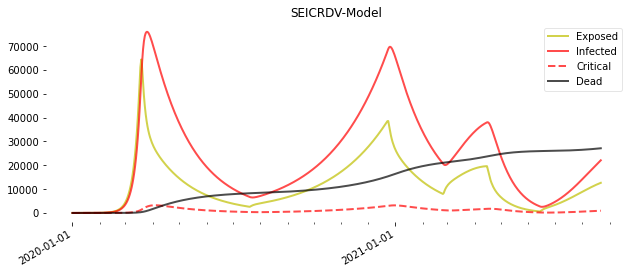

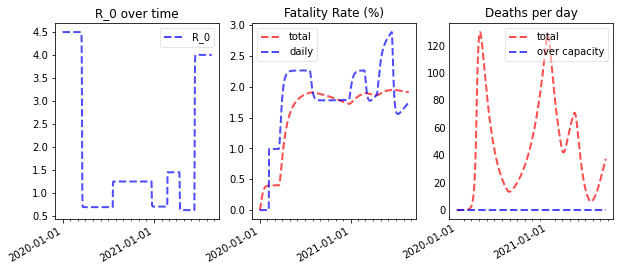

In [16]:
full_days = 600
first_date = np.datetime64(canada_data.index.min()) - np.timedelta64(outbreak_shift,'D')
x_ticks = pd.date_range(start=first_date, periods=full_days, freq="D")
print("Prediction for  Canada")
ret = Model(full_days, agegroup_lookup["Canada"], beds_lookup["Canada"], **result.best_values)
plotter(*ret, x_ticks=x_ticks)

actual = ret[1:9]
df = pd.DataFrame(actual).T
df.columns = ["S","E","I","C","R","D","V1", "V2"]
df.to_csv("canada_model_data_TEST.csv")

# ERROR ANALYSIS

In [17]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.utils import check_array
import math 

In [18]:
predicted_data = pd.read_csv("canada_model_data_TEST.csv") # deaths: col 6, v1: 7, v2: 8 

df1=canada_data.values 
df2=predicted_data.iloc[:592].values 

In [19]:
errors = []
for i in range (2,5):
    y_true = df1[:,i]
    y_pred = df2[:,i+4]
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    arr = [mae,rmse]
    errors.append(arr)
    i+=1

df = pd.DataFrame(errors,index=["D","V1","V2"],columns=["MAE","RMSE"])
df.head (n=3)

,MAE,RMSE
D,480.665157,6.292860e+02
V1,773281.952357,1.621577e+06
V2,342174.734192,6.834342e+05


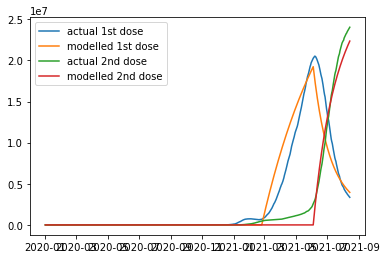

In [20]:
x_data = pd.date_range(start='2020-01-01', periods=592, freq="D")

plt.plot(x_data, df1[:,3], label = "actual 1st dose")
plt.plot(x_data, df2[:,7], label = "modelled 1st dose")
plt.plot(x_data, df1[:,4], label = "actual 2nd dose")
plt.plot(x_data, df2[:,8], label = "modelled 2nd dose")
plt.legend()
plt.show()


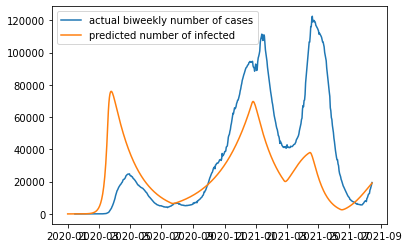

In [21]:
plt.plot(x_data, df1[:,5], label = "actual biweekly number of cases")
plt.plot(x_data, df2[:,3], label = "predicted number of infected")
plt.legend()
plt.show()